In [449]:
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import boxcox
from sklearn import svm
from sklearn import preprocessing

In [450]:
dfData = pd.read_csv("train.csv")

ModeAge = stat.mode(dfData['Age'])
ModeFare =  stat.mode(dfData['Fare'])
ModeEmbarked = stat.mode(dfData['Embarked'])

print(dfData.columns)
print(dfData.index)
dfData.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
RangeIndex(start=0, stop=891, step=1)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [451]:
def process_df_to_form(df):
    # dfTrain.loc[0,'Cabin']= np.nan
    df['Cabin'] = df['Cabin'].fillna('XX')

    df['Age'] = df['Age'].fillna(ModeAge)
    df['Fare'] = df['Fare'].fillna(ModeFare)
    df['Embarked'] = df['Embarked'].fillna(ModeEmbarked)
        
#     re.split('(\d+)',df.loc[0,"Cabin"])[0]    
#     df['CabinBlock'] = df.apply(lambda row : (re.split('(\d+)',row["Cabin"])[0]), axis=1)    
    df['CabinKnown'] = df.apply(lambda x: (0 if x["Cabin"]=='XX' else 1), axis = 1) 
    
    df1 = df.pop('Sex')
    df2 = df.pop('Embarked')
    df3 = df.pop('Age') # remove column b and store it in df1

    df['Sex']=df1
    df['Embarked']=df2
    df['Age']=df3 # add b series as a 'new' column.    
    
    df = df.drop(columns = ['Name','Ticket','Cabin'])
    df = df.drop(columns = ['PassengerId'])
    df = df.drop(columns = ['Fare'])
#     df = df.drop(columns = ['Embarked'])
    
    return(df)
    
dfData = process_df_to_form(dfData.copy())
dfData.head()

,Survived,Pclass,SibSp,Parch,CabinKnown,Sex,Embarked,Age
0,0,3,1,0,0,male,S,22.0
1,1,1,1,0,1,female,C,38.0
2,1,3,0,0,0,female,S,26.0
3,1,1,1,0,1,female,S,35.0
4,0,3,0,0,0,male,S,35.0


# Visualizing the data 

Pclass
SibSp
Parch
CabinKnown
Sex
Embarked
Age


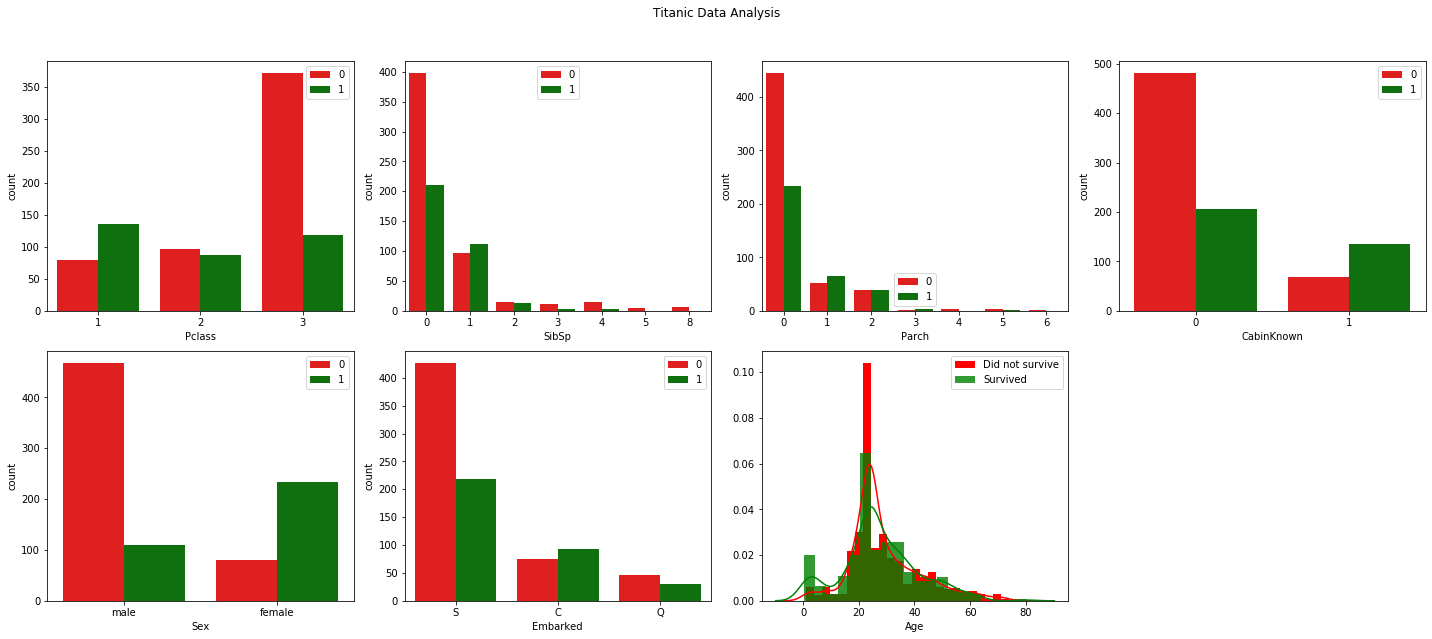

In [452]:
dtypesTitanic = dfData.loc[:, dfData.columns != 'Survived'].dtypes

fig = plt.figure(figsize = (20, 25))
#sns.set(font_scale=1.2)
j = 0
clrs = ['r','g']
for i, k in zip(dfData.loc[:, dfData.columns != 'Survived'].columns, dtypesTitanic):
    if k == 'float64':
        plt.subplot(6, 4, j+1)
        j += 1
        print(i)
        sns.distplot(dfData[i][dfData['Survived']==0], color='r', label = 'Did not survive', 
                     hist_kws={'alpha':1})
        sns.distplot(dfData[i][dfData['Survived']==1], color='g', label = 'Survived', 
                    hist_kws={'alpha':0.8})
        plt.legend(loc='best')
    else:
#         dfTrain[i] = dfTrain[i].astype('category')
        plt.subplot(6, 4, j+1)
        j += 1
        print(i)
        sns.countplot(x=i, hue="Survived", data=dfData, palette=clrs)
#         sns.countplot(dfTrain[i][dfTrain['Survived']==0], color='r', label = 'Did not survive')
#         sns.countplot(dfTrain[i][dfTrain['Survived']==1], color='g', label = 'Survived')
        plt.legend(loc='best')
fig.suptitle('Titanic Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# Pre-processing Data

In [453]:
yData = dfData.Survived;
dfData = dfData.drop(columns = ['Survived'])

In [454]:
def train_CV_test(DataIndex, TrainFrac, CVFrac):
    Train = int(TrainFrac*len(dfData))
    CV = Train + int(CVFrac*len(dfData))

    TrainIndex = DataIndex[:Train]
    CVIndex = DataIndex[Train+1:CV]
    TestIndex = DataIndex[CV+1:]
    
    return(TrainIndex, CVIndex, TestIndex)

def accuracy_pred(yPred, yTrue):
    Accuracy = (sum(abs(yPred - yTrue))/len(yTrue)*100)
    return(Accuracy)

In [455]:
def get_x_y_from_df(df, fitted_lambda):
#     df = re_arrange_df(df)
    
    df = df.drop(columns = ["CabinKnown"])
    
    v = df.to_numpy(copy=True)
    age, v = df['Age'], v[:,0:-1]
    enc.fit(v[:,-2:])
    inputs = enc.transform(v[:,-2:]) #.toarray()

    age = boxcox(age, fitted_lambda)
#     age = (OriginalAge - minAge) / (maxAge - minAge)

    x = np.c_[v[:,:-3], inputs, age]
    return(x) #, OriginalAge)

In [456]:
DataIndex = np.arange(len(dfData))
np.random.shuffle(DataIndex)
TrainFrac, CVFrac = 0.6, 0.2
TrainIndex, CVIndex, TestIndex = train_CV_test(DataIndex, TrainFrac, CVFrac)

dfTrain = dfData.loc[TrainIndex]
dfCV = dfData.loc[CVIndex] #dfData.drop(TrainData, axis=0)#dfData[~bad_df] #dfData[:590];
dfTest = dfData.loc[TestIndex]

ytrain = yData.loc[TrainIndex]
yCV =  yData.loc[CVIndex]
ytest = yData.loc[TestIndex]   

enc = preprocessing.OrdinalEncoder()
minAge, maxAge = min(dfTrain['Age']), max(dfTrain['Age'])
AgeData,fitted_lambda = boxcox(dfData.Age)

In [457]:
ageDataSet = np.array([20]);

xtrain = get_x_y_from_df(dfTrain.copy(), fitted_lambda) 
xCV = get_x_y_from_df(dfCV.copy(), fitted_lambda)

acc = np.empty([1,1])
accCV = np.empty([1,1])
Coeffs = [10, 7, 5, 3.33, 2, 1, 0.33, 0.1, 0.033]
# Gammas = [0.33, 0.2, 0.1, 0.033]

for C in Coeffs:
    clf = svm.SVC(gamma='scale', C=C)
    (clf.fit(xtrain, ytrain)) 

    yPred = clf.predict(xtrain)
    acc = np.append(acc, np.array([[accuracy_pred(yPred, ytrain)]]), axis = 0)
#     print('\nAccuracy on training set: %.2f%%' % (accuracy_pred(yPred, ytrain)))

    yPred = clf.predict(xCV)
    accCV = np.append(accCV, np.array([[accuracy_pred(yPred, yCV)]]), axis = 0)
#     print('Accuracy on cross-validation set: %.2f%%' % (accuracy_pred(yPred, yCV)))

# v.shape
# from sklearn import svm
# X = [[0, 0], [1, 1]]
# y = [0, 1]
# clf = svm.SVC(gamma='scale')
# clf.fit(X, y)
# clf.predict([[2., 2.]])

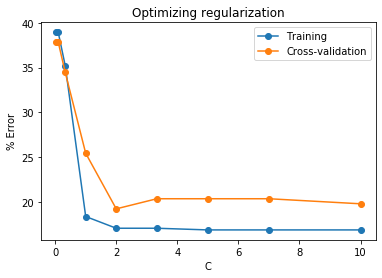

In [458]:
p1 = plt.plot(Coeffs,(acc[1:,:]),'o-',label = 'Training' )
p2 = plt.plot(Coeffs,(accCV[1:,:]),'o-', label = 'Cross-validation')
plt.legend()
plt.title('Optimizing regularization')
plt.xlabel("C")
plt.ylabel("% Error")
plt.show()

In [459]:
C = 2
yPred = clf.predict(xtrain)
clf = svm.SVC(gamma='scale', C=C)
clf.fit(xtrain, ytrain)

yPred = clf.predict(xtrain)
print('\nError on training set: %.2f%%' % (accuracy_pred(yPred, ytrain)))

yPred = clf.predict(xCV)
print('Error on cross-validation set: %.2f%%' % (accuracy_pred(yPred, yCV)))

xtest = get_x_y_from_df(dfTest.copy(),fitted_lambda)
yPredTtest = clf.predict(xtest)
print('Error on test set: %.2f%%' % (accuracy_pred(yPredTtest, ytest)))


Error on training set: 17.04%
Error on cross-validation set: 19.21%
Error on test set: 22.47%


In [460]:
# from sklearn.neural_network import MLPClassifier
# # X = [[0., 0.], [1., 1.]]
# # y = [0, 1]
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                      hidden_layer_sizes=(5, 2), random_state=1)

# clf.fit(xtrain, ytrain)      

# yPred = clf.predict(xtrain)
# print('\nError on training set: %.2f%%' % (accuracy_pred(yPred, ytrain)))

# yPred = clf.predict(xCV)
# print('Error on cross-validation set: %.2f%%' % (accuracy_pred(yPred, yCV)))

# Final Predictions

In [461]:
dfToPred = pd.read_csv('test.csv')
dfToPred.head()
dfOut = pd.DataFrame({"PassengerId": dfToPred.PassengerId})

dfToPred = process_df_to_form(dfToPred.copy())
dfToPred.head()

toJoin = 1
xToPred = get_x_y_from_df(dfToPred.copy(), fitted_lambda)

yToPred = clf.predict(xToPred)
dfOut["Survived"] = yToPred
sum(dfOut.Survived)

153

In [462]:
export_csv = dfOut.to_csv (r'export_dataframe.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path

# Do we need more features OR Data?

In [463]:
# from itertools import izip
DataIndex = np.arange(len(dfData))

TrainFrac = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
CVFrac = [0.8 - x for x in TrainFrac]

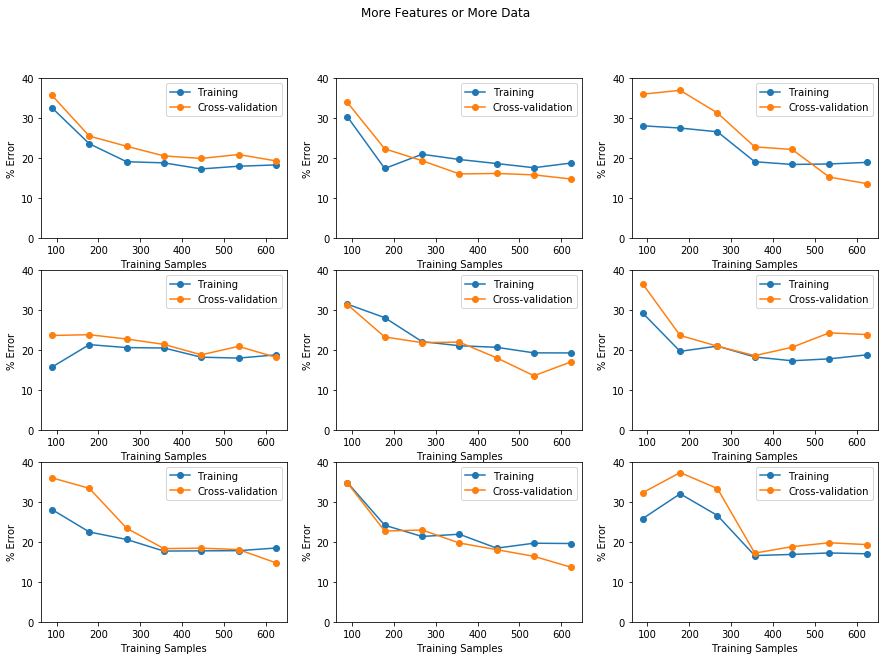

In [464]:
fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=False, figsize=(15, 10))
for i in range(3):
    for j in range(3): # Varying size of training and cross-validation set
        np.random.shuffle(DataIndex)
        acc = np.empty([1,1])
        accCV = np.empty([1,1])

        for TFrac, CFrac in zip(TrainFrac, CVFrac):
            TrainIndex, CVIndex, TestIndex = train_CV_test(DataIndex, TFrac, CFrac)

            dfTrain = dfData.loc[TrainIndex]
            dfCV = dfData.loc[CVIndex] #dfData.drop(TrainData, axis=0)#dfData[~bad_df] #dfData[:590];

            ytrain = yData.loc[TrainIndex]
            yCV =  yData.loc[CVIndex]   

            minAge, maxAge = min(dfTrain['Age']), max(dfTrain['Age'])
            xtrain = get_x_y_from_df(dfTrain.copy(), fitted_lambda) 
            xCV = get_x_y_from_df(dfCV.copy(), fitted_lambda)

            yPred = clf.predict(xtrain)
            clf = svm.SVC(gamma='scale', C=C)
            clf.fit(xtrain, ytrain)

            yPred = clf.predict(xtrain)
            acc = np.append(acc, np.array([[accuracy_pred(yPred, ytrain)]]), axis = 0)

            yPred = clf.predict(xCV)
            accCV = np.append(accCV, np.array([[accuracy_pred(yPred, yCV)]]), axis = 0)


        p1 = axs[i,j].plot([len(dfData)*x for x in TrainFrac],(acc[1:,:]),'o-',label = 'Training' )
        p2 = axs[i,j].plot([len(dfData)*x for x in TrainFrac],(accCV[1:,:]),'o-', label = 'Cross-validation')
        axs[i,j].legend()
        axs[i,j].set_xlabel("Training Samples")
        axs[i,j].set_ylabel("% Error")
        axs[i,j].set_ylim([0, 40])
        
# fig.subplots_adjust(top=0.88)        
fig.suptitle('More Features or More Data')
plt.show()

#### From the error plots between cross-validation and training set it is clear that increasing data points does not bring down the error, this indicates that we need more features for better prediction

In [465]:
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.75:
#             if columns[j]:
#                 columns[j] = False
#                 selected_columns = dfTrain.columns[columns]
#                 dfTrain = dfTrain[selected_columns]

In [466]:
# dfTrain.Fare = -np.log(dfTrain.Fare)

# corr = dfTrain.corr()
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.heatmap(corr)
# plt.show()